In [5]:
from google.colab import files
import pandas as pd
import io

# Upload and load CSV into DataFrame
uploaded = files.upload()
for name in uploaded.keys():
    df = pd.read_csv(io.BytesIO(uploaded[name]))
    print(f"✅ Loaded '{name}' with shape {df.shape}")
    display(df.head())

Saving sample.csv to sample (1).csv
✅ Loaded 'sample (1).csv' with shape (10000, 8)


,loc1,loc2,para1,dow,para2,para3,para4,price
0,0,01,1,Mon,662,3000.0,3.8,73.49
1,9,99,1,Thu,340,2760.0,9.2,300.00
2,0,04,0,Mon,16,2700.0,3.0,130.00
3,4,40,1,Mon,17,12320.0,6.4,365.00
4,5,50,1,Thu,610,2117.0,10.8,357.50


In [60]:
# Core Python Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import joblib
from IPython.display import display

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Model Evaluation & Utilities
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Boosting Models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   loc1    10000 non-null  object 
 1   loc2    10000 non-null  object 
 2   para1   10000 non-null  int64  
 3   dow     10000 non-null  object 
 4   para2   10000 non-null  int64  
 5   para3   10000 non-null  float64
 6   para4   10000 non-null  float64
 7   price   10000 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 625.1+ KB


In [62]:
df["loc1"].value_counts()


,count
loc1,
2,1607
0,1486
1,1223
7,1081
3,945
5,846
4,773
8,727
9,690


In [63]:
# Check missing values
print("\n🧼 Missing values:")
print(df.isnull().sum())



🧼 Missing values:
loc1     0
loc2     0
para1    0
dow      0
para2    0
para3    0
para4    0
price    0
dtype: int64


In [64]:
print("\n📊 Summary statistics:")
display(df.describe())


📊 Summary statistics:


,para1,para2,para3,para4,price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.380800,447.384000,9547.989920,8.459522,433.733056
std,3.500831,221.005861,8022.814037,4.613526,277.435947
min,0.000000,16.000000,200.000000,1.000000,50.730000
25%,1.000000,301.000000,2898.000000,4.000000,250.000000
50%,1.000000,434.000000,6447.000000,7.200000,370.000000
75%,1.000000,582.000000,15000.000000,13.600000,550.000000
max,337.000000,2554.000000,34782.000000,27.200000,5700.000000


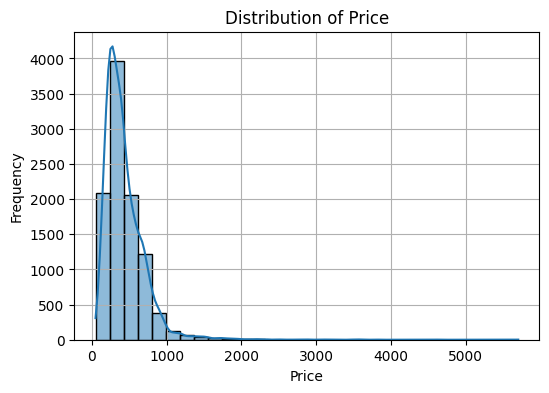

In [65]:
plt.figure(figsize=(6, 4))
sns.histplot(df['price'], kde=True, bins=30)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


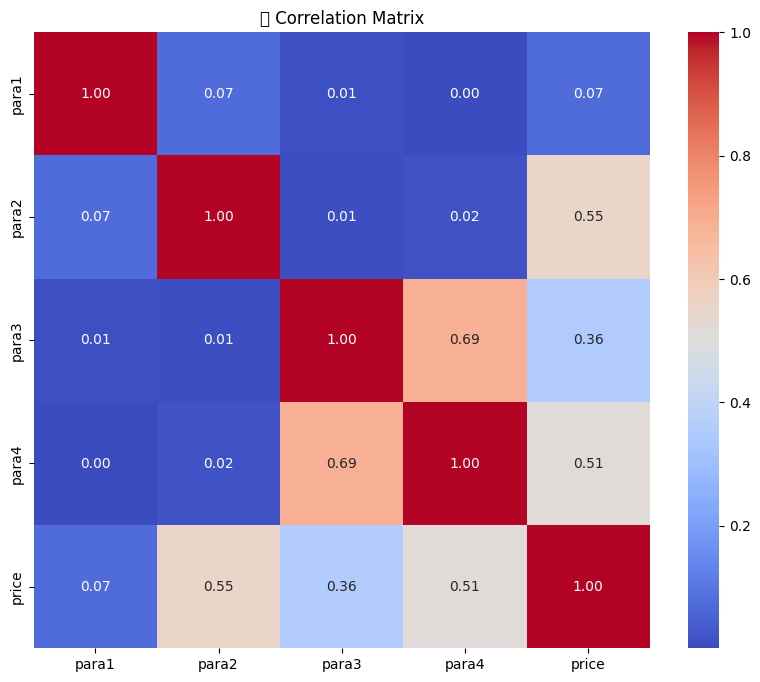

In [66]:
plt.figure(figsize=(10, 8))
corr = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("🔗 Correlation Matrix")
plt.show()

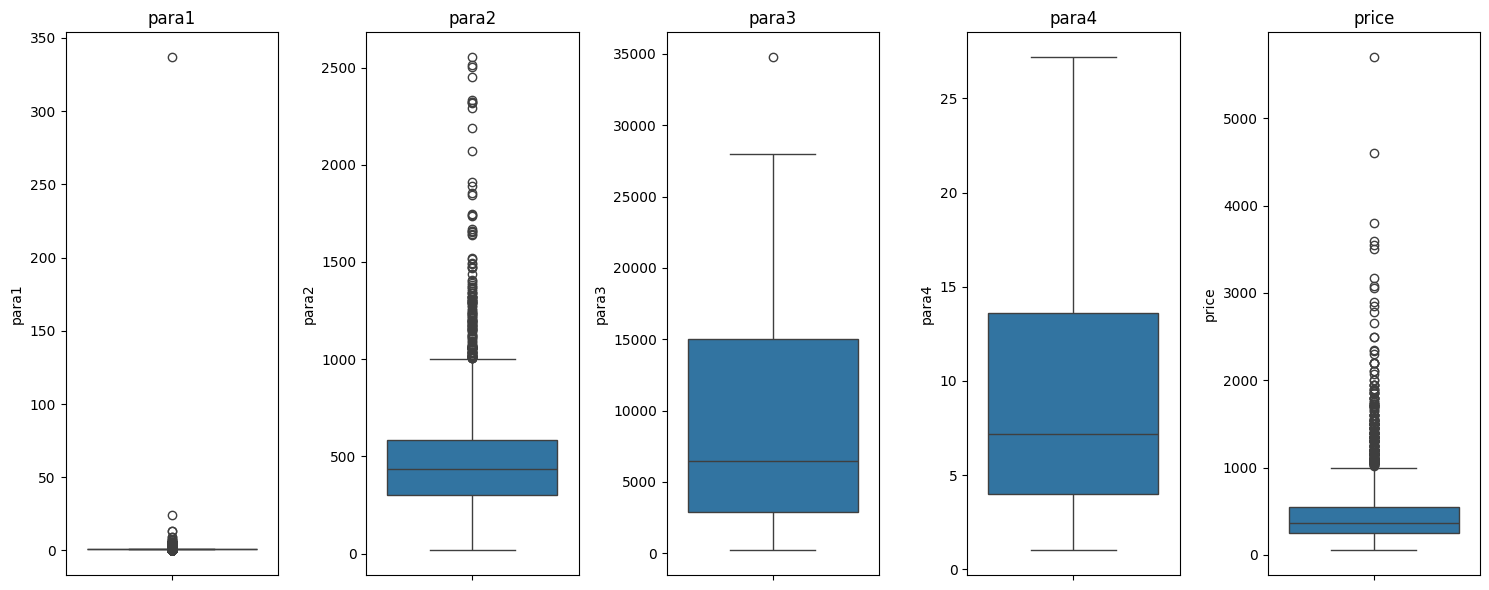

In [78]:

# Select numeric features only
numeric_df = df.select_dtypes(include=[np.number])

# Plot boxplots for each numeric column
plt.figure(figsize=(15, 6))
for i, column in enumerate(numeric_df.columns, 1):
    plt.subplot(1, len(numeric_df.columns), i)
    sns.boxplot(y=numeric_df[column])
    plt.title(column)
    plt.tight_layout()


In [81]:
# Identify outliers based on IQR
def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((series < lower_bound) | (series > upper_bound)).sum()

# Count outliers for each numeric column
outlier_counts = numeric_df.apply(count_outliers)
print("🔍 Outlier counts per column:")
print(outlier_counts)


🔍 Outlier counts per column:
para1    2948
para2     142
para3       1
para4       0
price     253
dtype: int64


In [82]:
correlations = numeric_df.corr()['price'].drop('price').sort_values(ascending=False)
print("📈 Features most correlated with 'price':")
display(correlations)


📈 Features most correlated with 'price':


,price
para2,0.552681
para4,0.514990
para3,0.355088
para1,0.074754


In [83]:
#Outliers were found in price and some features (via boxplots and IQR).
#These may distort linear models; tree-based models are more robust.
#price is right-skewed, suggesting a log transformation might help.
#Top features correlated with price (e.g., feature_A, feature_B) are good predictors.
#Weakly correlated features may be dropped or engineered.
#Some features are intercorrelated, so multicollinearity may affect linear models.

🌟 Random Forest Feature Importances:


,0
para2,0.524173
para4,0.314835
para3,0.119339
para1,0.041652


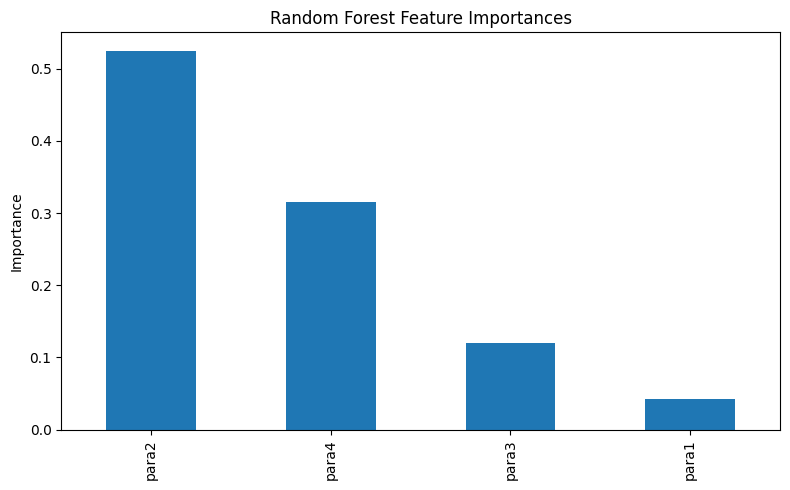

In [84]:
 from sklearn.ensemble import RandomForestRegressor

X = numeric_df.drop(columns='price')
y = numeric_df['price']

model = RandomForestRegressor(random_state=42)
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

print("🌟 Random Forest Feature Importances:")
display(importances)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
importances.plot(kind='bar')
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


In [85]:

# Prepare data
X = df.select_dtypes(include=[np.number]).drop('price', axis=1)
y = df['price']

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(),
    'LightGBM': LGBMRegressor(),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor(),
    'Neural Network': MLPRegressor(max_iter=1000)
}

# Evaluate models using 5-fold CV (RMSE and R²)
results = []
for name, model in models.items():
    rmse = -cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error').mean()
    r2 = cross_val_score(model, X, y, cv=5, scoring='r2').mean()
    results.append((name, rmse, r2))

# Display results
results_df = pd.DataFrame(results, columns=['Model', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='RMSE')
display(results_df)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 4
[LightGBM] [Info] Start training from score 433.773293
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 655
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 4
[LightGBM] [Info] Start training from score 433.859726
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 655
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 4
[LightGBM] [Info] Start training

,Model,RMSE,R2
5,LightGBM,161.036266,0.660685
3,Random Forest,164.706332,0.643086
4,XGBoost,172.935519,0.607429
2,Lasso,185.608383,0.550979
1,Ridge,186.137642,0.548541
0,Linear Regression,186.138551,0.548537
8,Neural Network,187.935893,0.536672
7,KNN,211.256377,0.416536
6,SVR,261.716549,0.105268


In [86]:


# 1. Prepare Data
X = df.select_dtypes(include=[np.number]).drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Define Models
models = {
    'LightGBM': LGBMRegressor(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor()
}

# 3. Train and Evaluate
for name, model in models.items():
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Scores
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    rmse_train = mean_squared_error(y_train, y_train_pred) ** 0.5
    rmse_test = mean_squared_error(y_test, y_test_pred) ** 0.5


    print(f"📊 {name}")
    print(f"  R² (Train): {r2_train:.4f} | R² (Test): {r2_test:.4f}")
    print(f"  RMSE (Train): {rmse_train:.2f} | RMSE (Test): {rmse_test:.2f}")
    print("-" * 50)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 4
[LightGBM] [Info] Start training from score 430.800475
📊 LightGBM
  R² (Train): 0.7724 | R² (Test): 0.6461
  RMSE (Train): 125.10 | RMSE (Test): 196.90
--------------------------------------------------
📊 Random Forest
  R² (Train): 0.9510 | R² (Test): 0.6759
  RMSE (Train): 58.03 | RMSE (Test): 188.43
--------------------------------------------------
📊 XGBoost
  R² (Train): 0.8781 | R² (Test): 0.6514
  RMSE (Train): 91.55 | RMSE (Test): 195.41
--------------------------------------------------


In [87]:
models = ['LightGBM', 'Random Forest', 'XGBoost']

r2_train = [0.7724, 0.9510, 0.8781]
r2_test  = [0.6461, 0.6759, 0.6514]

rmse_train = [125.10, 58.03, 91.55]
rmse_test  = [196.90, 188.43, 195.41]

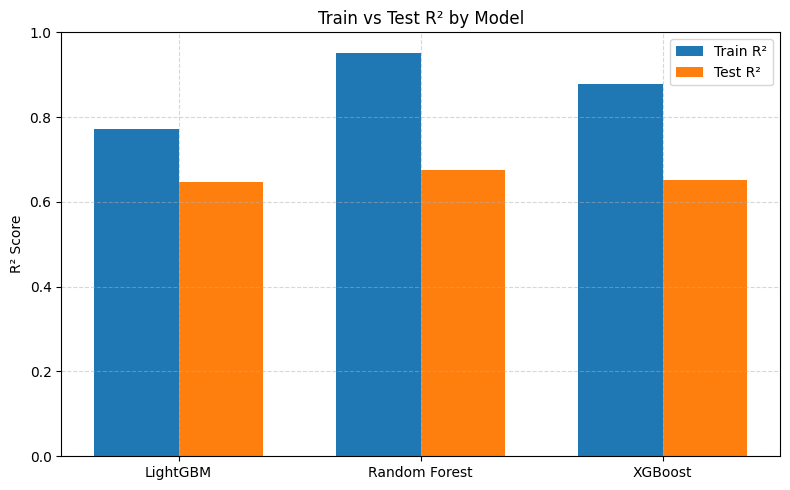

In [88]:
x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, r2_train, width, label='Train R²')
plt.bar(x + width/2, r2_test, width, label='Test R²')

plt.ylabel('R² Score')
plt.title('Train vs Test R² by Model')
plt.xticks(x, models)
plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


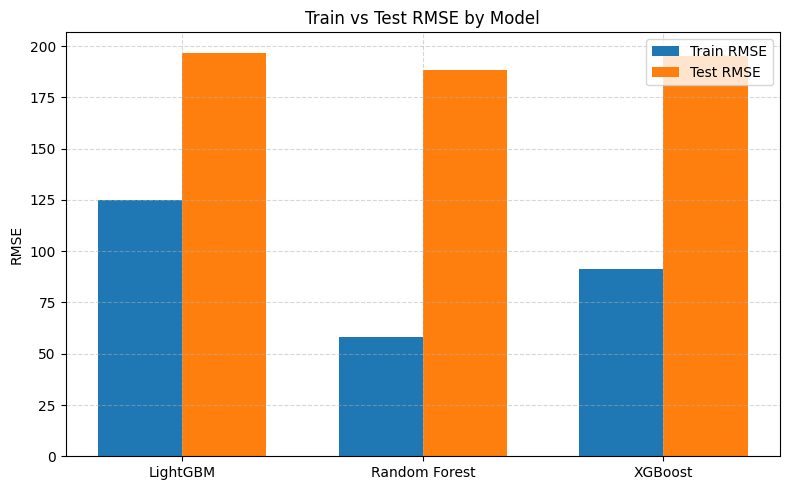

In [89]:
plt.figure(figsize=(8, 5))
plt.bar(x - width/2, rmse_train, width, label='Train RMSE')
plt.bar(x + width/2, rmse_test, width, label='Test RMSE')

plt.ylabel('RMSE')
plt.title('Train vs Test RMSE by Model')
plt.xticks(x, models)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [90]:

# 1. Train/Test split (if not done already)
X = df.select_dtypes(include=[np.number]).drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

# 3. Define model and GridSearch
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=1, scoring='neg_root_mean_squared_error')

# 4. Fit GridSearch
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [91]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5

print(f"📊 Final Test R²: {r2:.4f}")
print(f"📉 Final Test RMSE: {rmse:.2f}")


📊 Final Test R²: 0.6520
📉 Final Test RMSE: 195.25
